Modeling the pair collision of four vorticities using NODE: part 1

In [ ]:
%pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import random 
import numpy as np
import torch


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# #file saving location
# My Drive > Colab Notebooks > VortexDanceTDA > Vortex_Pair > Data > vortex_fields > t100-101x101
folder = 'vortex-pair-collision'
data_dir = f'/content/gdrive/My Drive/Colab Notebooks/VortexDanceTDA/{folder}/Data/'
model_dir = f'/content/gdrive/My Drive/Colab Notebooks/VortexDanceTDA/{folder}/Model/'
result_dir = f'/content/gdrive/My Drive/Colab Notebooks/VortexDanceTDA/{folder}/Results/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


In [ ]:
data = np.load(data_dir+'omega_tracks_vortex-tracks.npy')
data.shape

(59, 100, 8)

In [ ]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

# Assuming your dataset is stored in 'data' with shape (noIC, timestep, 2)
noIC, timestep, dimz = data.shape

# Reshape the data to (noIC*timestep, 2) for scaling
scaled_data = data.reshape(noIC * timestep, dimz)

# Apply min-max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(scaled_data)

# Reshape the scaled data back to the original shape
scaled_data = scaled_data.reshape(noIC, timestep, dimz)

In [ ]:
noTimesteps = data.shape[1]

In [ ]:
def visualize(dataY=None, predY=None, itr = 00, dty=None):

  if predY is not None and dataY is not None:
    brk = int(dataY.shape[1] / 2)
    fig, ax = plt.subplots(figsize=(6, 6))

    xSet = dataY[:, :brk]
    ySet = dataY[:, brk:]

    pxset = predY[:, :brk]
    pyset = predY[:, brk:]

    
    for vortex in range(brk):
      if vortex == 0:
        ax.plot(xSet[:, vortex], ySet[:, vortex],color='darkblue',linewidth=2.5, label='True trajectory ')
        ax.plot(pxset[:, vortex], pyset[:, vortex], color='darkorange',linewidth=2.5, linestyle='dotted',
                        label='Predicted trajectory ')
      else:
        ax.plot(xSet[:, vortex], ySet[:, vortex],color='darkblue',linewidth=2.5 )
        ax.plot(pxset[:, vortex], pyset[:, vortex], color='darkorange', linestyle='dotted',linewidth=2.5,)
    ax.legend()
    # ax.grid(True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.tight_layout()
    
    if dty is not None :
      plt.savefig(result_dir+dty+'/' + folder + '_track_' + '{itr:04d}'.format(itr=itr) + '.png')
    plt.show()

  else:
    
    for ic in range(dataY.shape[0]):
      fig = plt.figure( figsize=(6, 6), facecolor='white')
      ax = fig.add_subplot(111)
      brk = int(dataY.shape[2] / 2)


      xSet=dataY[ic, :, :brk]
      ySet=dataY[ic, :, brk:]


      for vortex in range(brk):  
        ax.plot(xSet[:, vortex] ,ySet[:, vortex], label='True trajectory {}'.format(vortex+1))

      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()



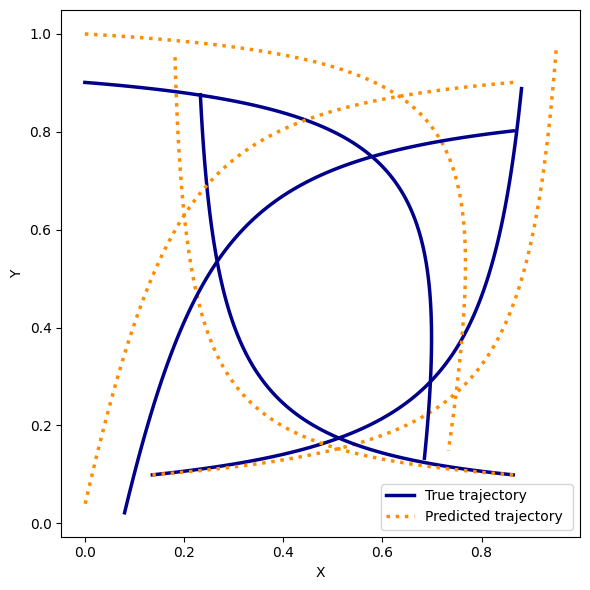

In [ ]:
visualize(dataY = scaled_data[4], predY = scaled_data[2])

# test train split

In [ ]:
from sklearn.model_selection import train_test_split

dataTrain, dataTest = train_test_split(scaled_data, test_size=0.05, random_state=42)
dataTest, dataValidate = train_test_split(dataTest, test_size=0.5, random_state=43)

print(dataTrain.shape, dataTest.shape, dataValidate.shape)

(56, 100, 8) (1, 100, 8) (2, 100, 8)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

from torchdiffeq import odeint

In [ ]:
# converting data to tensors

nODE_train = torch.tensor(dataTrain ).type(torch.float32)
nODE_test = torch.tensor(dataTest ).type(torch.float32)
nODE_valid = torch.tensor(dataValidate ).type(torch.float32)

print(nODE_train.shape, nODE_test.shape, nODE_valid.shape)

torch.Size([56, 100, 8]) torch.Size([1, 100, 8]) torch.Size([2, 100, 8])


ReLU (Rectified Linear Unit): ReLU is a simple and widely used activation function that computes the output as the maximum between zero and the input. It has been successful in many applications, including vortex dynamics, due to its ability to model sparse and discontinuous features.

Leaky ReLU: Leaky ReLU is an extension of the ReLU function that introduces a small slope for negative input values, instead of zero. This helps alleviate the "dying ReLU" problem where neurons can become non-responsive. Leaky ReLU can be beneficial for capturing different gradients and enhancing the robustness of the model.

ELU (Exponential Linear Unit): ELU is similar to Leaky ReLU but with an exponential function for negative input values. ELU has a smoother transition for negative inputs and allows the activation function to have negative values. This property can be advantageous for modeling complex and diverse vortex dynamics.

Swish: Swish is a recently proposed activation function that applies a sigmoid function to the input and multiplies it with the input itself. It combines the benefits of non-linearity and saturation control, which can aid in capturing intricate vortex behaviors.

Tanh (Hyperbolic Tangent): Tanh is a classic activation function that squashes input values between -1 and 1. It is symmetric around the origin and can capture both positive and negative activations. Tanh can be suitable for modeling vortex dynamics that exhibit symmetric patterns.

These activation functions are readily available in popular deep learning libraries like PyTorch, TensorFlow, and Keras. You can choose and experiment with these alternatives to find the activation function that best suits your specific vortex dynamics modeling task.








In [ ]:
def fullyConnectedBlock(inD, outD, activFun):
  # if activFun == 'tanh':
  #   act = nn.Tanh()
  # elif activFun == 'sigmoid':
  #   act= nn.Sigmoid()
  # elif activFun == 'relu':
  #   act = nn.ReLU()
  # elif activFun == 'swish':
  #   act = nn.SiLU()
  # else:
  #   act = nn.SELU()

  return nn.Sequential(
      nn.Linear(inD,outD),
      activFun
  )

class CreateNODEFunction(nn.Module):
  """
  layerSizes : an tuple of size n
  layerSizes = [dimension of the system, Hidden layers dimensions, Output dimension]
  
  """
  def __init__(self, layerSizes, activations) -> None:
    super().__init__()

    layersCreated = [fullyConnectedBlock(inD, outD, activFun)
                      for inD, outD, activFun in zip(layerSizes[:-1], layerSizes[1:-1], activations)]
    layersCreated.append(nn.Sequential(nn.Linear(layerSizes[-2],layerSizes[-1])))
  
    
    self.network_model = nn.Sequential(*layersCreated)


    for m in self.network_model.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)
    

  def forward(self, t, y):
    output = self.network_model(y)
    return output


In [ ]:
t = torch.linspace(0,1, steps=noTimesteps).type(torch.float32)
Dim = nODE_train.shape[-1]
batch_time = 12
batch_size = 32
data_size = nODE_train.shape[1] # total time steps
noICs_train = nODE_train.shape[0]

In [ ]:
# creating the NODE model
func = CreateNODEFunction([Dim,800, 800,800, Dim], [nn.ReLU(), nn.ReLU(), nn.ReLU()])
print(func)

CreateNODEFunction(
  (network_model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=800, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=800, out_features=800, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=800, out_features=800, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=800, out_features=8, bias=True)
    )
  )
)


In [ ]:
# Selecting batches to train the model

# setting up batches in same trajectory but with various starting points
# consecative batch_size points with different starting point

def get_batch():
  # selecting roandom trajectory
  ic = np.random.randint(noICs_train-1)

  trajec = nODE_train[ic]
  
  # random starting points equl to batch_size
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype = np.int64), batch_size, replace=False))

  batch_y0 = trajec[s] #(batch_size, dim)

  batch_t = t[:batch_time] #(T)
  batch_y = torch.stack([trajec[s+i] for i in range(batch_time)], dim=0) #(time, batch_size, dim)

  return batch_y0, batch_t, batch_y, ic

In [ ]:
solver_adjoint = False
niters = 5000
lossesIter = []
saveTrain = []

if solver_adjoint:
  from torchdiffeq import odeint_adjoint as odeint


optimizer =  optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()


for iter in tqdm(range(niters + 1)):

  optimizer.zero_grad()

  batch_y0, batch_t, batch_y,trajec = get_batch()

  predY = odeint(func=func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(predY - batch_y))

  loss.backward()
  optimizer.step()


  #testing
  if iter % 5 == 0:
    with torch.no_grad():
      trueData = nODE_test[0]
      y0 = trueData[0,:]
      predData = odeint(func, y0 = y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
      saveTrain.append([predData])

      loss = torch.mean(torch.abs(predData -trueData))
      lossesIter.append([iter,loss])
      print("Iter {:04d}| Total Loss {:6f}".format(iter, loss.item()))

      if iter == niters :
        visualize(dataY=trueData, predY= predData, itr= iter)#, dty='test')

      # if iter % 1000 == 0:
      #   tpLoss = [torch.mean(t) for t in torch.abs(trueData-predData)]
      #   lastIterLoss=np.array(tpLoss )
      #   plt.figure()
      #   plt.plot(lastIterLoss[:], label=f'Iteration:{str(iter)}')
      #   plt.legend()
      #   plt.xlabel('timestep')
      #   plt.ylabel('Loss')
      #   plt.title('Single step error between true data and NODE output')
      #   plt.savefig(f'{result_dir}/tpLoss/tpLoss_itr_{iter}.png')

      # if iter % 1000 == 0 and iter != 0:
      #   lossIter = np.array(lossesIter)
      #   np.save(f'{result_dir}/Loss_{iter}_iter_dim50.npy',lossIter )
      # if iter == niters:
      #   plt.figure()
      #   plt.plot(lossIter[:,0],lossIter[:,1])
      #   plt.xlabel('Iteration')
      #   plt.ylabel('Loss')
      #   plt.title('loss vs Iteration')
      #   plt.savefig(f'{result_dir}/lossIter/lossIter_itr_{iter}.png')

saveTrain.append([nODE_test[0]])
print(len(saveTrain))
np.save(f'{result_dir}saveTrain_dim800.npy',saveTrain )
end_time = time.time() - start_time

print("Process time: {}sec".format(end_time))

In [ ]:
#Save the model
#file saving location
PATH = f'{model_dir}save_node_model_track_800'

torch.save(func.state_dict(), PATH)


# # load the model
# func = CreateNODEFunction([Dim, 500,500, Dim], ['selu','selu'])
func.load_state_dict(torch.load(PATH))
# func.eval()

<All keys matched successfully>

In [ ]:
import imageio
import glob

kargs = { 'duration': 0.5 }
PATH = sorted(glob.glob(f'{result_dir}/test/*.png'))

images = []
for filename in PATH:
    if folder in filename:
      images.append(imageio.imread(filename))
imageio.mimsave(f'{result_dir}test/{folder}_movie_ts.gif', images, **kargs)

<ipython-input-19-e94cf3fc33a8>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [ ]:
with torch.no_grad():
  for i in range(nODE_valid.shape[0]):

    true_y = nODE_valid[i,:,:]
    y0 = true_y[0,:]
    predY = odeint(func, y0 = y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')

    loss = torch.mean(torch.abs(predY -true_y))
    print("Iter {:04d}| Total Loss {:6f}".format(iter, loss.item()))

    visualize(dataY=true_y, predY= predY, itr= i, dty='valid')

In [ ]:
data = np.load(f'/content/gdrive/My Drive/Colab Notebooks/VortexDanceTDA/{folder}/Results/saveTrain.npy', allow_pickle=True)
data.shape

(1002, 1)

In [ ]:
data[0][0].shape

torch.Size([100, 8])

In [ ]:
predSet=data[1:-1]
predSet.shape

(1000, 1)

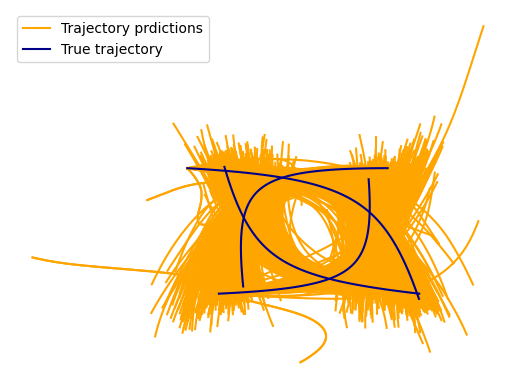

In [ ]:
# figsize=(6, 6),
fig = plt.figure(  facecolor='white')
ax = fig.add_subplot(111)

pred = predSet[0][0]
brk = int(pred.shape[1] / 2)

xSet=pred[:, :brk]
ySet=pred[:, brk:]

for vortex in range(brk):
  if vortex ==0 :
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'orange', label='Trajectory prdictions')
  else:
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'orange')


for i,pred in enumerate(predSet):
  pred = pred[0]
  brk = int(pred.shape[1] / 2)

  xSet=pred[:, :brk]
  ySet=pred[:, brk:]

  for vortex in range(brk):  
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'orange')

pred = data[-1][0]
brk = int(pred.shape[1] / 2)

xSet=pred[:, :brk]
ySet=pred[:, brk:]

for vortex in range(brk): 
  if vortex ==0 : 
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'darkblue', label = "True trajectory")
  else:
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'darkblue')

plt.legend()
plt.axis('off')
# plt.grid(True)
# plt.tight_layout()
plt.show()
  

In [ ]:
data = np.load(f'/content/gdrive/My Drive/Colab Notebooks/VortexDanceTDA/{folder}/Results/saveTrain_dim800.npy', allow_pickle=True)
data.shape

(1002, 1)

In [ ]:
true = data[-1][0]
true.shape

torch.Size([100, 8])

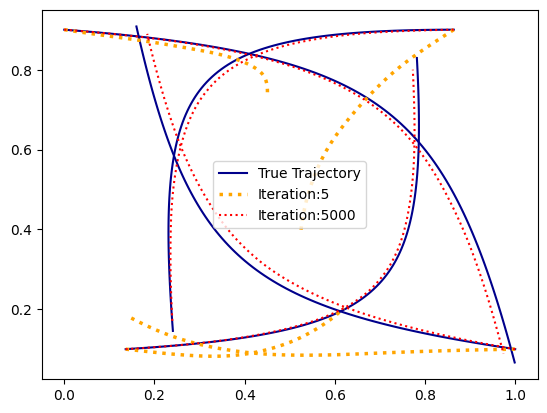

In [ ]:
# drawing true  and itr=2, itr=5000 at the same graph

fig = plt.figure(  facecolor='white')
ax = fig.add_subplot(111)

true = data[-1][0]
brk = int(true.shape[1] / 2)

xSet=true[:, :brk]
ySet=true[:, brk:]

for vortex in range(brk):
  if vortex ==0 :
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'darkblue', label='True Trajectory')
  else:
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'darkblue')

iter2 = data[1][0]
brk = int(iter2.shape[1] / 2)

xSet=iter2[:, :brk]
ySet=iter2[:, brk:]

for vortex in range(brk):
  if vortex ==0 :
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'orange', linestyle='dotted', label='Iteration:5',
            linewidth=2.5)
  else:
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'orange', linestyle='dotted', linewidth=2.5)


iter5000 = data[-4][0]
brk = int(iter5000.shape[1] / 2)

xSet=iter5000[:, :brk]
ySet=iter5000[:, brk:]

for vortex in range(brk):
  if vortex ==0 :
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'red',linestyle='dotted', label='Iteration:5000')
  else:
    ax.plot(xSet[:, vortex] ,ySet[:, vortex], color = 'red', linestyle='dotted')
plt.legend()
plt.show()

